In [9]:
import pandas as pd
import os
# 1. Wczytanie danych
df = pd.read_csv('data/train_set.csv')  # lub np. 'data/segmented_customers_full.csv'

# 2. Feature Engineering 2
df_fe2 = df.copy()

# 3. Dodanie binarnej zmiennej Is_USD (jeśli jeszcze nie ma)
if 'Currency' in df_fe2.columns:
    df_fe2['Is_USD'] = (df_fe2['Currency'] == 'USD').astype(int)

# 4. Usunięcie informacji o lokalizacji i walutach
df_fe2 = df_fe2.drop(columns=[col for col in df_fe2.columns if col.startswith('Branch_') or col.startswith('Currency_')])

# 5. Usunięcie kolumny 'Branch' i 'Currency' (jeśli zostały w oryginale)
for col in ['Branch', 'Currency']:
    if col in df_fe2.columns:
        df_fe2 = df_fe2.drop(columns=col)

# 6. Podgląd
print(df_fe2.head())


   Transaction Amount  Account Balance  Transaction_To_Balance_Ratio  \
0            0.449397         0.526415                      0.042769   
1            0.071532         0.379330                      0.009683   
2            0.245214         0.634017                      0.019461   
3            0.654205         0.890133                      0.036793   
4            0.873531         0.973322                      0.044896   

   Is_High_Value_Transaction  High_Balance_flag  \
0                          0                  0   
1                          0                  0   
2                          0                  0   
3                          0                  1   
4                          1                  1   

   Account_Transaction_Current - Debit  \
0                                    0   
1                                    0   
2                                    0   
3                                    0   
4                                    0   

   Acco

In [11]:
# Zapis do pliku
os.makedirs('data', exist_ok=True)
df_fe2.to_csv('data/final_data_fe2.csv', index=False)


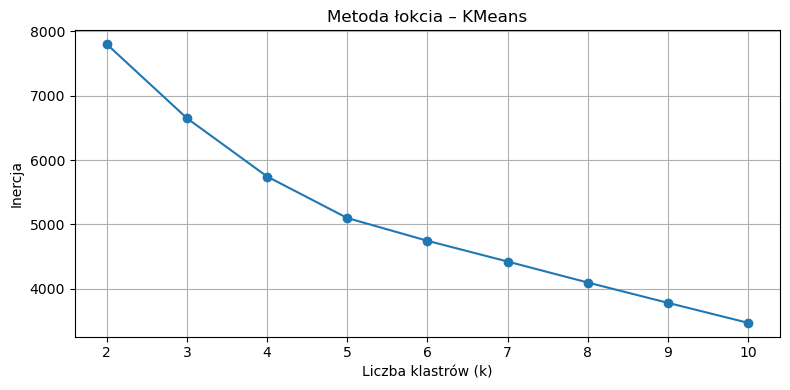

In [15]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_fe2)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(k_range, inertia, marker='o')
plt.title('Metoda łokcia – KMeans')
plt.xlabel('Liczba klastrów (k)')
plt.ylabel('Inercja')
plt.grid(True)
plt.tight_layout()
plt.show()


In [17]:
k = 5  # <- dostosuj na podstawie wykresu łokcia
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
df_fe2['KMeans_FE2'] = kmeans.fit_predict(df_fe2)


In [19]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

X_only = df_fe2.drop(columns='KMeans_FE2')
sil_score = silhouette_score(X_only, df_fe2['KMeans_FE2'])
db_score = davies_bouldin_score(X_only, df_fe2['KMeans_FE2'])

print(f"📊 Silhouette Score: {sil_score:.3f} (bliżej 1 lepiej)")
print(f"📉 Davies-Bouldin Score: {db_score:.3f} (bliżej 0 lepiej)")


📊 Silhouette Score: 0.239 (bliżej 1 lepiej)
📉 Davies-Bouldin Score: 1.240 (bliżej 0 lepiej)


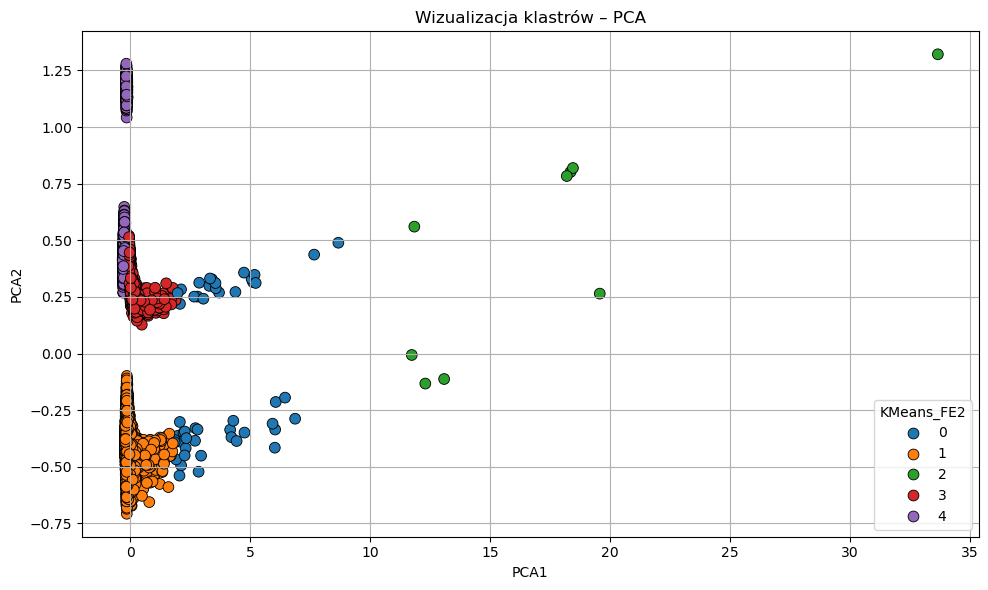

In [21]:
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_only)

df_fe2['PCA1'] = X_pca[:, 0]
df_fe2['PCA2'] = X_pca[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_fe2, x='PCA1', y='PCA2', hue='KMeans_FE2', palette='tab10', s=60, edgecolor='black')
plt.title('Wizualizacja klastrów – PCA')
plt.grid(True)
plt.tight_layout()
plt.show()


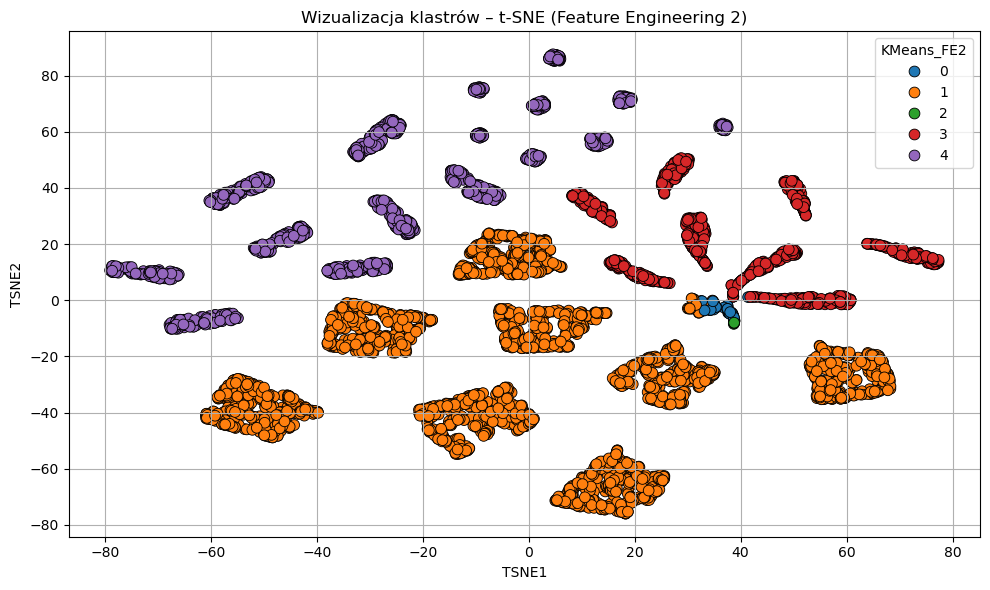

In [23]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

# Dane bez kolumny z etykietą klastra
X_tsne_input = df_fe2.drop(columns=['KMeans_FE2'])

# t-SNE redukcja do 2D
tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', init='pca', random_state=42)
X_tsne = tsne.fit_transform(X_tsne_input)

# Dodanie do DataFrame
df_fe2['TSNE1'] = X_tsne[:, 0]
df_fe2['TSNE2'] = X_tsne[:, 1]

# Wizualizacja
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_fe2,
    x='TSNE1',
    y='TSNE2',
    hue='KMeans_FE2',
    palette='tab10',
    s=60,
    edgecolor='black'
)
plt.title('Wizualizacja klastrów – t-SNE (Feature Engineering 2)')
plt.grid(True)
plt.tight_layout()
plt.show()


In [25]:
# Średnie wartości cech w każdym klastrze
cluster_profile = df_fe2.groupby('KMeans_FE2').mean().T.round(2)
display(cluster_profile)


KMeans_FE2,0,1,2,3,4
Transaction Amount,0.68,0.38,0.73,0.88,0.51
Account Balance,0.01,0.38,0.00,0.39,0.88
Transaction_To_Balance_Ratio,3.80,0.11,17.71,0.22,0.03
Is_High_Value_Transaction,0.41,0.00,0.56,1.00,0.25
High_Balance_flag,0.00,0.00,0.00,0.00,1.00
Account_Transaction_Current - Debit,0.12,0.12,0.44,0.12,0.13
Account_Transaction_Fixed Deposit - Credit,0.08,0.12,0.00,0.15,0.14
Account_Transaction_Fixed Deposit - Debit,0.18,0.12,0.11,0.11,0.11
Account_Transaction_Recurring Deposit - Credit,0.12,0.13,0.11,0.11,0.12
Account_Transaction_Recurring Deposit - Debit,0.08,0.12,0.11,0.12,0.12


##  Podział na klastry zaproponowany przez LLM (GPT-4o)

### **0 – Aggressive Spenders**  
**Bardzo aktywni klienci o niskim saldzie.**  
Regularnie wykonują transakcje mimo braku środków.

---

### **1 – Passive-LowValue**  
**Pasywni, niskowartościowi użytkownicy.**  
Niskie saldo i mało transakcji.

---

### **2 – Overdrawn-HighActivity**  
**Skrajnie aktywni użytkownicy bez środków.**  
Intensywnie korzystają z konta mimo zera na rachunku.

---

### **3 – HighRollers**  
**Najbardziej aktywni i zamożni użytkownicy.**  
Wysokie transakcje, duża operacyjność.

---

### **4 – Wealthy-Inactive**  
**Najzamożniejsi, ale mało aktywni klienci.**  
Rzadko wykonują operacje.
